# Домашнее задание 9. Настройка композиций алгоритмов

В этом задании вы настроите случайный лес, градиентный бустинг, а также их композицию на данных
соревнования [Mercedes-Benz Greener Manufacturing](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing).

Данные загружаются сразу из гитхаба ниже.

Кратко о задаче: объекты - автомобили, целевая переменная - время, за которое автомобиль проходит тест, задача регрессии, качество измеряется с помощью $R^2$-метрики.

Скрипт загрузки и базовой предобработки данных взят с [Kaggle Kernels](https://www.kaggle.com/anokas/mercedes-eda-xgboost-starter-0-55/notebook). В этом же ядре приводится базовый exploration данных.

## Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/nadiinchi/hse_cs_ml_course_2017_FTAD/master/materials/train.csv')
print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
df_train.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


Распределение целевого признака:

min: 72.11 max: 265.32 mean: 100.66931812782134 std: 12.6778749695168
Count of values above 180: 1


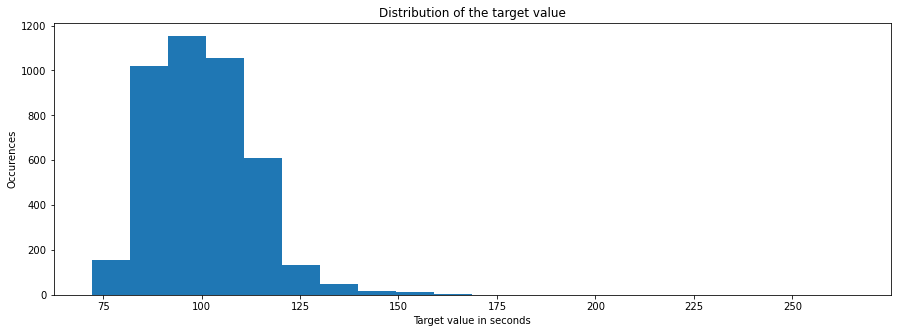

In [3]:
y_train = df_train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 200)))

Число признаков и объектов:

In [4]:
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

Приведение данных к вещественному виду:

In [5]:
usable_columns = list(set(df_train.columns) - set(['ID', 'y']))
y_train = df_train['y'].values
x_train = df_train[usable_columns]
for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1) # Column with only one value is useless so we drop it
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        
x_train.head()

<ipython-input-5-86fbcd4c84a1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[column] = x_train[column].apply(mapper)


,X246,X126,X167,X231,X328,X104,X4,X160,X0,X230,...,X335,X29,X71,X140,X60,X34,X131,X208,X105,X122
0,0,0,0,0,0,0,100,0,107,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,100,0,107,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,100,0,219,0,...,0,1,1,0,0,0,0,0,0,0
3,1,0,0,0,1,0,100,0,219,0,...,0,1,1,0,0,0,0,0,0,0
4,1,0,0,0,1,0,100,0,219,0,...,0,1,0,0,0,0,0,0,0,0


## Разделение данных
Разделим данные на три части. Первую будем использовать для настройки случайного леса и градиентного бустинга, вторую - для настройки композиции, третью - для итогового контроля.

In [6]:
x_train.shape, y_train.shape

((4209, 376), (4209,))

In [7]:
from sklearn.utils import shuffle

In [8]:
x_train, y_train = shuffle(x_train, y_train, random_state=1)

In [9]:
x1, y1 = x_train[:2000], y_train[:2000]
x1.shape, y1.shape

((2000, 376), (2000,))

In [10]:
x2, y2 = x_train[2000:3000], y_train[2000:3000]
x2.shape, y2.shape

((1000, 376), (1000,))

In [11]:
x3, y3 = x_train[3000:], y_train[3000:]
x3.shape, y3.shape

((1209, 376), (1209,))

## Настройка моделей

На занятиях мы обсуждали, что поскольку случайный лес и градиентный бустинг разрабатывались исходя из разных принципов, то и базовые алгоритмы - решающие деревья - им нужны разные. Отсюда вытекает, что какие-то гиперапараметры более важны, а какие-то - менее важны для каждого из этих алгоритмов. Для каждого из алгоритмов мы будем сначала подбирать наиболее важные для него гиперапраметры, а затем - втоостепенные.

Для случайного леса самый важный гиперпараметр - max_features (сколько случайно выбранных признаков перебирать при построении вершины), потому что он влияет на то, насколько различными будут деревья (а это основная идея случайного леса). В частности, если вы меняете признаковое пространство (а значит, и число признаков), то этот гиперпараметр надо подбирать заново. После настройки max_features подбираются остальные гиперпараметры.

Для градиентного бустинга самые важные гиперпараметры - число деревьев и глубина дерева. Глубина дерева задает, насколько слабыми или сильными будут отдельные деревья, а значит и то, насколько мы будем двигаться в сторону градиента. После этих гиперпараметров подбирают другие гиперпараметры. 

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import GridSearchCV

В этой части вам надо найти оптимальные гиперпараметры для случайного леса и градиентного бустинга, используя первую часть выборки (x1, y1).

__Задание 1.__
Начнем со случайного леса. 
1. (уже сделано ниже) Постройте график зависимости качества от числа деревьев в случайном лесе на кросс-валидации с 3 блоками. Выберите число деревьев для использования в дальнейшей настройке и при итоговом обучении модели.
1. __(1.25 балла)__ Постройте график зависимости качества от max_features на кросс-валидации. Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите оптимальное значение гиперпараметра.
1. __(1.25 балла)__ С помощью кросс-валидации выберите оптимальные значения для max_depth, min_samples_leaf, min_samples_split. В этом пункте не нужно строить график, только выбрать лучшее значение. Обратите внимание, что в этом пункте нужно использовать max_features, выбранное на предыдущем шаге.
1. __(0.5 балла)__ Обучите случайный лес с выбранными гиперпараметрами на всей выборке x1, y1.

Указания: verbose=3 в GridSearchCV будет выводить значения качества на каждой обучаемой модели. Рекомендуется в экспериментах зафиксировать random_state у модели. Если вы перезапускаете ядро, старайтесь не перезапускать все ячейки перебора гиперпараметров (они могут долго считаться, кроме того, могут измениться оптимальные гиперпараметры, если вы не везде зафиксировали random state), перезапускайте только те ячейки, результаты которых используются дальше. В данном блоке это только ячейка, отвечающая за последний пункт (итоговое обучение случайного леса).

Если вдруг получилось, что вы перезапустили ячейки с grid search, и у вас изменились оптимальные гиперпараметры, при этом ранее полученные гиперпараметры уже использованы ниже в ноутбуке, напишите об этом пояснение и не переделывайте другие задания.

In [13]:
param_grid = {"n_estimators":2**np.arange(10)} #  логарифмическая шкала
gs = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)

In [14]:
gs.fit(x1, y1)

/Users/nbagiyan/Environments/jupyter_env/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1 ..................................................
[CV] ............ n_estimators=1, score=-0.163571011784, total=   0.0s
[CV] n_estimators=1 ..................................................
[CV] ............. n_estimators=1, score=-1.44854137266, total=   0.0s
[CV] n_estimators=1 ..................................................
[CV] ........... n_estimators=1, score=-0.0343370221034, total=   0.0s
[CV] n_estimators=2 ..................................................
[CV] ............. n_estimators=2, score=0.128982128318, total=   0.0s
[CV] n_estimators=2 ..................................................
[CV] ............ n_estimators=2, score=-0.307029643262, total=   0.0s
[CV] n_estimators=2 ..................................................
[CV] ............. n_estimators=2, score=0.171963456125, total=   0.1s
[CV] n_estimators=4 ..................................................
[CV] ...........

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.2min finished
/Users/nbagiyan/Environments/jupyter_env/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2_score), verbose=3)

Text(0,0.5,'R2')

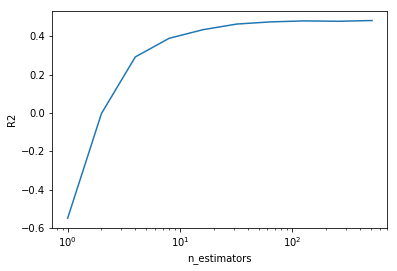

In [15]:
plt.plot((param_grid["n_estimators"]), gs.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("n_estimators")
plt.ylabel("R2")

Качество, как и ожидается, растет с увеличением числа базовых алгоритмов. Для валидации выберем 100 деревьев (быстро обучается и уже более-менее приналежит области стабильности качества), финальную модель будем обучать с 500 деревьями.

In [14]:
# базовая логарифмическая шкала для max_features
param_grid = {"max_features":2**np.arange(1, 9)}
gs = GridSearchCV(RandomForestRegressor(n_estimators = 100, random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)
gs.fit(x1, y1)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] max_features=2 ..................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... max_features=2, score=0.421, total=   0.6s
[CV] max_features=2 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ...................... max_features=2, score=0.503, total=   0.6s
[CV] max_features=2 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] ...................... max_features=2, score=0.579, total=   0.7s
[CV] max_features=2 ..................................................
[CV] ...................... max_features=2, score=0.258, total=   0.6s
[CV] max_features=2 ..................................................
[CV] ...................... max_features=2, score=0.367, total=   0.5s
[CV] max_features=4 ..................................................
[CV] ...................... max_features=4, score=0.442, total=   0.6s
[CV] max_features=4 ..................................................
[CV] ...................... max_features=4, score=0.523, total=   0.6s
[CV] max_features=4 ..................................................
[CV] ...................... max_features=4, score=0.604, total=   0.6s
[CV] max_features=4 ..................................................
[CV] ...................... max_features=4, score=0.275, total=   0.7s
[CV] max_features=4 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   38.6s finished


GridSearchCV(estimator=RandomForestRegressor(random_state=1, warm_start=True),
             param_grid={'max_features': array([  2,   4,   8,  16,  32,  64, 128, 256], dtype=int32)},
             scoring=make_scorer(r2_score), verbose=3)

Text(0, 0.5, 'R2')

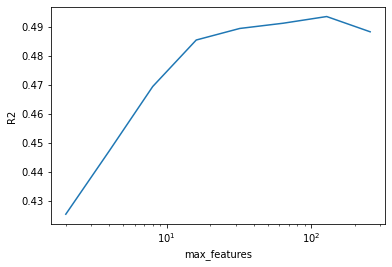

In [16]:
plt.plot((param_grid["max_features"]), gs.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("max_features")
plt.ylabel("R2")

Сначала качество модели растёт с увеличением количества признаков, затем, примерно на 100 признаках, достигает пика и начинает снижаться. Это ожидаемо, поскольку с ростом количества признаков деревья все более и более начинают быть похожими друг на друга, начинают коррелировать, это снижает точность результатов.

In [17]:
gs.best_params_ #128 признаков возьмем для дальнейшей работы

{'max_features': 128}

In [18]:
# базовая шкала для остальных гиперпараметров
param_grid = {"max_depth":np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], "min_samples_split":[3, 9, 27, 81]}
gs = GridSearchCV(RandomForestRegressor(n_estimators = 100, max_features = 128, random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)
gs.fit(x1, y1)

C:\Users\79150\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass scoring=make_scorer(r2_score) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.353, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.408, total=   0.2s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.449, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.240, total=   0.2s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.363, total=   0.2s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.353, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.408, total=   0.3s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.449, total=   0.2s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_s

[CV]  max_depth=1, min_samples_leaf=9, min_samples_split=81, score=0.353, total=   0.2s
[CV] max_depth=1, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=1, min_samples_leaf=9, min_samples_split=81, score=0.408, total=   0.2s
[CV] max_depth=1, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=1, min_samples_leaf=9, min_samples_split=81, score=0.449, total=   0.3s
[CV] max_depth=1, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=1, min_samples_leaf=9, min_samples_split=81, score=0.240, total=   0.2s
[CV] max_depth=1, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=1, min_samples_leaf=9, min_samples_split=81, score=0.363, total=   0.3s
[CV] max_depth=1, min_samples_leaf=27, min_samples_split=3 ...........
[CV]  max_depth=1, min_samples_leaf=27, min_samples_split=3, score=0.353, total=   0.2s
[CV] max_depth=1, min_samples_leaf=27, min_samples_split=3 ...........
[CV]  max_depth=1, min_samples_leaf=27, min_sa

[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=9, score=0.676, total=   0.4s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=9, score=0.371, total=   0.4s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=9, score=0.525, total=   0.4s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=27 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=27, score=0.517, total=   0.4s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=27 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=27, score=0.643, total=   0.4s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=27 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_samples_split=27, score=0.677, total=   0.4s
[CV] max_depth=3, min_samples_leaf=3, min_samples_split=27 ...........
[CV]  max_depth=3, min_samples_leaf=3, min_sample

[CV]  max_depth=3, min_samples_leaf=27, min_samples_split=81, score=0.521, total=   0.4s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, score=0.525, total=   0.5s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, score=0.638, total=   0.5s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, score=0.695, total=   0.5s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, score=0.371, total=   0.5s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=3, score=0.523, total=   0.5s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=5, min_samples_leaf=1, min_samples

[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=27, score=0.642, total=   0.5s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=27 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=27, score=0.697, total=   0.5s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=27 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=27, score=0.371, total=   0.5s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=27 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=27, score=0.527, total=   0.5s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=81, score=0.525, total=   0.5s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_samples_split=81, score=0.640, total=   0.5s
[CV] max_depth=5, min_samples_leaf=9, min_samples_split=81 ...........
[CV]  max_depth=5, min_samples_leaf=9, min_sam

[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, score=0.365, total=   0.7s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=3 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=3, score=0.524, total=   0.6s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=9, score=0.527, total=   0.7s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=9, score=0.626, total=   0.6s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=9, score=0.692, total=   0.6s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_split=9, score=0.368, total=   0.6s
[CV] max_depth=7, min_samples_leaf=3, min_samples_split=9 ............
[CV]  max_depth=7, min_samples_leaf=3, min_samples_s

[CV]  max_depth=7, min_samples_leaf=27, min_samples_split=81, score=0.523, total=   0.5s
[CV] max_depth=7, min_samples_leaf=27, min_samples_split=81 ..........
[CV]  max_depth=7, min_samples_leaf=27, min_samples_split=81, score=0.634, total=   0.6s
[CV] max_depth=7, min_samples_leaf=27, min_samples_split=81 ..........
[CV]  max_depth=7, min_samples_leaf=27, min_samples_split=81, score=0.686, total=   0.5s
[CV] max_depth=7, min_samples_leaf=27, min_samples_split=81 ..........
[CV]  max_depth=7, min_samples_leaf=27, min_samples_split=81, score=0.361, total=   0.5s
[CV] max_depth=7, min_samples_leaf=27, min_samples_split=81 ..........
[CV]  max_depth=7, min_samples_leaf=27, min_samples_split=81, score=0.527, total=   0.5s


[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  2.3min finished


GridSearchCV(estimator=RandomForestRegressor(max_features=128, random_state=1,
                                             warm_start=True),
             param_grid={'max_depth': array([1, 3, 5, 7]),
                         'min_samples_leaf': [1, 3, 9, 27],
                         'min_samples_split': [3, 9, 27, 81]},
             scoring=make_scorer(r2_score), verbose=3)

In [19]:
gs.best_params_ #'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 81}

{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 81}

In [20]:
rf = rf = RandomForestRegressor (n_estimators = 500, max_depth = 5, max_features = 128, min_samples_leaf = 3, min_samples_split =81)
rf.fit (x1, y1)

RandomForestRegressor(max_depth=5, max_features=128, min_samples_leaf=3,
                      min_samples_split=81, n_estimators=500)

__Задание 2.__

Теперь настроим градиентный бустинг, используя ту же выборку x1, y1.

1.  __(1.5 балла)__ Запустите кросс-валидацию для GradentBoostingRegressor по n_estimators и learning_rate. Постройте двумерный график или несколько одномерных (например, график качество-число деревьев при разных значениях длины шага). При построении графиков используйте логарифмическую шкалу по оси абсцисс (вызовите np.log2 или используйте plt.xscale("log")). Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите значения для использования при дальнейшей настройке и для финального обучения модели.
1.  __(1.25 балла)__ Постройте график зависимости качества от max_depth на кросс-валидации. Прокомментируйте график: ожидаете ли вы такое поведение, или результат нестандартный? Выберите оптимальное значение гиперпараметра.
1.  __(1.25 балла)__ Выберите оптимальные значения для min_samples_split, min_samples_leaf, max_features с помощью кросс-валидации. В этом пункте не нужно строить график. Обратите внимание, что в этом пункте нужно исползьзовать ранее выбранные гиперпараметры.
1.  __(0.5 балла)__ Обучите итоговую модель с выбранными значениями гиперпараметров на всей выборке x1, y1.

Примеры построения трехмерных графиков [здесь](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html).

In [21]:
# базовая шкала для числа деревьев и длины шага
param_grid = {"n_estimators":2**np.arange(10), "learning_rate":0.1**np.arange(5)}
gs = GridSearchCV (GradientBoostingRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)
gs.fit (x1, y1)

C:\Users\79150\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass scoring=make_scorer(r2_score) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV] ... learning_rate=1.0, n_estimators=1, score=0.524, total=   0.0s
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV] ... learning_rate=1.0, n_estimators=1, score=0.642, total=   0.0s
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV] ... learning_rate=1.0, n_estimators=1, score=0.702, total=   0.0s
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV] ... learning_rate=1.0, n_estimators=1, score=0.381, total=   0.0s
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV] ... learning_rate=1.0, n_estimators=1, score=0.488, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ... learning_rate=1.0, n_estimators=2, score=0.528, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV] ... learni

[CV] ... learning_rate=0.1, n_estimators=2, score=0.239, total=   0.0s
[CV] learning_rate=0.1, n_estimators=2 ...............................
[CV] ... learning_rate=0.1, n_estimators=2, score=0.132, total=   0.0s
[CV] learning_rate=0.1, n_estimators=2 ...............................
[CV] ... learning_rate=0.1, n_estimators=2, score=0.192, total=   0.0s
[CV] learning_rate=0.1, n_estimators=4 ...............................
[CV] ... learning_rate=0.1, n_estimators=4, score=0.291, total=   0.0s
[CV] learning_rate=0.1, n_estimators=4 ...............................
[CV] ... learning_rate=0.1, n_estimators=4, score=0.359, total=   0.0s
[CV] learning_rate=0.1, n_estimators=4 ...............................
[CV] ... learning_rate=0.1, n_estimators=4, score=0.399, total=   0.1s
[CV] learning_rate=0.1, n_estimators=4 ...............................
[CV] ... learning_rate=0.1, n_estimators=4, score=0.221, total=   0.1s
[CV] learning_rate=0.1, n_estimators=4 ...............................
[CV] .

[CV]  learning_rate=0.010000000000000002, n_estimators=8, score=0.075, total=   0.1s
[CV] learning_rate=0.010000000000000002, n_estimators=8 ..............
[CV]  learning_rate=0.010000000000000002, n_estimators=8, score=0.092, total=   0.1s
[CV] learning_rate=0.010000000000000002, n_estimators=8 ..............
[CV]  learning_rate=0.010000000000000002, n_estimators=8, score=0.101, total=   0.1s
[CV] learning_rate=0.010000000000000002, n_estimators=8 ..............
[CV]  learning_rate=0.010000000000000002, n_estimators=8, score=0.056, total=   0.1s
[CV] learning_rate=0.010000000000000002, n_estimators=8 ..............
[CV]  learning_rate=0.010000000000000002, n_estimators=8, score=0.083, total=   0.1s
[CV] learning_rate=0.010000000000000002, n_estimators=16 .............
[CV]  learning_rate=0.010000000000000002, n_estimators=16, score=0.139, total=   0.2s
[CV] learning_rate=0.010000000000000002, n_estimators=16 .............
[CV]  learning_rate=0.010000000000000002, n_estimators=16, scor

[CV]  learning_rate=0.0010000000000000002, n_estimators=8, score=0.003, total=   0.1s
[CV] learning_rate=0.0010000000000000002, n_estimators=8 .............
[CV]  learning_rate=0.0010000000000000002, n_estimators=8, score=0.008, total=   0.1s
[CV] learning_rate=0.0010000000000000002, n_estimators=16 ............
[CV]  learning_rate=0.0010000000000000002, n_estimators=16, score=0.016, total=   0.2s
[CV] learning_rate=0.0010000000000000002, n_estimators=16 ............
[CV]  learning_rate=0.0010000000000000002, n_estimators=16, score=0.019, total=   0.1s
[CV] learning_rate=0.0010000000000000002, n_estimators=16 ............
[CV]  learning_rate=0.0010000000000000002, n_estimators=16, score=0.018, total=   0.2s
[CV] learning_rate=0.0010000000000000002, n_estimators=16 ............
[CV]  learning_rate=0.0010000000000000002, n_estimators=16, score=0.009, total=   0.2s
[CV] learning_rate=0.0010000000000000002, n_estimators=16 ............
[CV]  learning_rate=0.0010000000000000002, n_estimator

[CV]  learning_rate=0.00010000000000000002, n_estimators=16, score=0.002, total=   0.2s
[CV] learning_rate=0.00010000000000000002, n_estimators=16 ...........
[CV]  learning_rate=0.00010000000000000002, n_estimators=16, score=0.001, total=   0.2s
[CV] learning_rate=0.00010000000000000002, n_estimators=16 ...........
[CV]  learning_rate=0.00010000000000000002, n_estimators=16, score=-0.002, total=   0.2s
[CV] learning_rate=0.00010000000000000002, n_estimators=16 ...........
[CV]  learning_rate=0.00010000000000000002, n_estimators=16, score=-0.002, total=   0.2s
[CV] learning_rate=0.00010000000000000002, n_estimators=16 ...........
[CV]  learning_rate=0.00010000000000000002, n_estimators=16, score=0.001, total=   0.2s
[CV] learning_rate=0.00010000000000000002, n_estimators=32 ...........
[CV]  learning_rate=0.00010000000000000002, n_estimators=32, score=0.003, total=   0.3s
[CV] learning_rate=0.00010000000000000002, n_estimators=32 ...........
[CV]  learning_rate=0.00010000000000000002, 

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  4.0min finished


GridSearchCV(estimator=GradientBoostingRegressor(random_state=1,
                                                 warm_start=True),
             param_grid={'learning_rate': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04]),
                         'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512], dtype=int32)},
             scoring=make_scorer(r2_score), verbose=3)

In [24]:
gs.best_params_ #будем дальше использовать эти параметры, исходя из предложения модели {'learning_rate': 0.010000000000000002, 'n_estimators': 512}

{'learning_rate': 0.010000000000000002, 'n_estimators': 512}

In [25]:
# базовая шкала для max_depth
param_grid = {"max_depth":np.arange(1, 9)}
gs = GridSearchCV (GradientBoostingRegressor(learning_rate = 0.010000000000000002, n_estimators= 512, random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)
gs.fit (x1, y1)

C:\Users\79150\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass scoring=make_scorer(r2_score) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.486, total=   1.9s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ......................... max_depth=1, score=0.591, total=   1.7s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ......................... max_depth=1, score=0.649, total=   1.8s
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.340, total=   1.8s
[CV] max_depth=1 .....................................................
[CV] ......................... max_depth=1, score=0.493, total=   1.8s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.529, total=   3.1s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.644, total=   3.0s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.702, total=   3.1s
[CV] max_depth=2 .....................................................
[CV] ......................... max_depth=2, score=0.375, total=   3.1s
[CV] max_depth=2 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  4.4min finished


GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.010000000000000002,
                                                 n_estimators=512,
                                                 random_state=1,
                                                 warm_start=True),
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8])},
             scoring=make_scorer(r2_score), verbose=3)

Text(0, 0.5, 'R2')

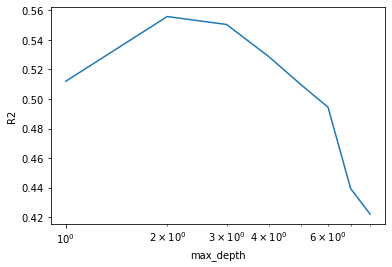

In [26]:
plt.plot((param_grid["max_depth"]), gs.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("max_depth")
plt.ylabel("R2")

При увеличении глубины качество сначала увеличивается, а потом, достигая пика примерно в 2, резко снижается, поскольку с ростом глубины наступает переобучение модели. Вероятно, лучшим значением глубины будет 2. Это подтверждается результатами лучших параметров из GridSearchCV.

In [27]:
gs.best_params_

{'max_depth': 2}

In [28]:
# базовая шкала для остальных гиперпараметров
param_grid = {"max_features":2**np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], 
              "min_samples_split":[3, 9, 27, 81]}
gs = GridSearchCV (GradientBoostingRegressor(learning_rate = 0.010000000000000002, n_estimators= 512, max_depth = 2, random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)
gs.fit (x1, y1)

C:\Users\79150\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass scoring=make_scorer(r2_score) as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.290, total=   0.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.365, total=   0.2s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.395, total=   0.2s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.199, total=   0.2s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.291, total=   0.2s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.290, total=   0.2s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.366, total=   0.2s
[CV] max_features=2, min_samples_l

[CV]  max_features=2, min_samples_leaf=9, min_samples_split=27, score=0.386, total=   0.2s
[CV] max_features=2, min_samples_leaf=9, min_samples_split=27 ........
[CV]  max_features=2, min_samples_leaf=9, min_samples_split=27, score=0.194, total=   0.2s
[CV] max_features=2, min_samples_leaf=9, min_samples_split=27 ........
[CV]  max_features=2, min_samples_leaf=9, min_samples_split=27, score=0.286, total=   0.2s
[CV] max_features=2, min_samples_leaf=9, min_samples_split=81 ........
[CV]  max_features=2, min_samples_leaf=9, min_samples_split=81, score=0.283, total=   0.2s
[CV] max_features=2, min_samples_leaf=9, min_samples_split=81 ........
[CV]  max_features=2, min_samples_leaf=9, min_samples_split=81, score=0.355, total=   0.2s
[CV] max_features=2, min_samples_leaf=9, min_samples_split=81 ........
[CV]  max_features=2, min_samples_leaf=9, min_samples_split=81, score=0.384, total=   0.2s
[CV] max_features=2, min_samples_leaf=9, min_samples_split=81 ........
[CV]  max_features=2, min_sa

[CV]  max_features=8, min_samples_leaf=3, min_samples_split=3, score=0.289, total=   0.2s
[CV] max_features=8, min_samples_leaf=3, min_samples_split=3 .........
[CV]  max_features=8, min_samples_leaf=3, min_samples_split=3, score=0.435, total=   0.2s
[CV] max_features=8, min_samples_leaf=3, min_samples_split=9 .........
[CV]  max_features=8, min_samples_leaf=3, min_samples_split=9, score=0.437, total=   0.2s
[CV] max_features=8, min_samples_leaf=3, min_samples_split=9 .........
[CV]  max_features=8, min_samples_leaf=3, min_samples_split=9, score=0.537, total=   0.2s
[CV] max_features=8, min_samples_leaf=3, min_samples_split=9 .........
[CV]  max_features=8, min_samples_leaf=3, min_samples_split=9, score=0.588, total=   0.2s
[CV] max_features=8, min_samples_leaf=3, min_samples_split=9 .........
[CV]  max_features=8, min_samples_leaf=3, min_samples_split=9, score=0.289, total=   0.2s
[CV] max_features=8, min_samples_leaf=3, min_samples_split=9 .........
[CV]  max_features=8, min_samples_

[CV]  max_features=8, min_samples_leaf=27, min_samples_split=27, score=0.433, total=   0.3s
[CV] max_features=8, min_samples_leaf=27, min_samples_split=81 .......
[CV]  max_features=8, min_samples_leaf=27, min_samples_split=81, score=0.433, total=   0.2s
[CV] max_features=8, min_samples_leaf=27, min_samples_split=81 .......
[CV]  max_features=8, min_samples_leaf=27, min_samples_split=81, score=0.531, total=   0.2s
[CV] max_features=8, min_samples_leaf=27, min_samples_split=81 .......
[CV]  max_features=8, min_samples_leaf=27, min_samples_split=81, score=0.580, total=   0.2s
[CV] max_features=8, min_samples_leaf=27, min_samples_split=81 .......
[CV]  max_features=8, min_samples_leaf=27, min_samples_split=81, score=0.284, total=   0.2s
[CV] max_features=8, min_samples_leaf=27, min_samples_split=81 .......
[CV]  max_features=8, min_samples_leaf=27, min_samples_split=81, score=0.430, total=   0.3s
[CV] max_features=32, min_samples_leaf=1, min_samples_split=3 ........
[CV]  max_features=32,

[CV]  max_features=32, min_samples_leaf=9, min_samples_split=9, score=0.517, total=   0.5s
[CV] max_features=32, min_samples_leaf=9, min_samples_split=9 ........
[CV]  max_features=32, min_samples_leaf=9, min_samples_split=9, score=0.630, total=   0.5s
[CV] max_features=32, min_samples_leaf=9, min_samples_split=9 ........
[CV]  max_features=32, min_samples_leaf=9, min_samples_split=9, score=0.684, total=   0.5s
[CV] max_features=32, min_samples_leaf=9, min_samples_split=9 ........
[CV]  max_features=32, min_samples_leaf=9, min_samples_split=9, score=0.352, total=   0.5s
[CV] max_features=32, min_samples_leaf=9, min_samples_split=9 ........
[CV]  max_features=32, min_samples_leaf=9, min_samples_split=9, score=0.524, total=   0.5s
[CV] max_features=32, min_samples_leaf=9, min_samples_split=27 .......
[CV]  max_features=32, min_samples_leaf=9, min_samples_split=27, score=0.517, total=   0.5s
[CV] max_features=32, min_samples_leaf=9, min_samples_split=27 .......
[CV]  max_features=32, min_

[CV]  max_features=128, min_samples_leaf=1, min_samples_split=81, score=0.646, total=   1.3s
[CV] max_features=128, min_samples_leaf=1, min_samples_split=81 ......
[CV]  max_features=128, min_samples_leaf=1, min_samples_split=81, score=0.702, total=   1.3s
[CV] max_features=128, min_samples_leaf=1, min_samples_split=81 ......
[CV]  max_features=128, min_samples_leaf=1, min_samples_split=81, score=0.372, total=   1.4s
[CV] max_features=128, min_samples_leaf=1, min_samples_split=81 ......
[CV]  max_features=128, min_samples_leaf=1, min_samples_split=81, score=0.531, total=   1.4s
[CV] max_features=128, min_samples_leaf=3, min_samples_split=3 .......
[CV]  max_features=128, min_samples_leaf=3, min_samples_split=3, score=0.529, total=   1.4s
[CV] max_features=128, min_samples_leaf=3, min_samples_split=3 .......
[CV]  max_features=128, min_samples_leaf=3, min_samples_split=3, score=0.646, total=   1.4s
[CV] max_features=128, min_samples_leaf=3, min_samples_split=3 .......
[CV]  max_features

[CV]  max_features=128, min_samples_leaf=27, min_samples_split=9, score=0.703, total=   1.3s
[CV] max_features=128, min_samples_leaf=27, min_samples_split=9 ......
[CV]  max_features=128, min_samples_leaf=27, min_samples_split=9, score=0.371, total=   1.3s
[CV] max_features=128, min_samples_leaf=27, min_samples_split=9 ......
[CV]  max_features=128, min_samples_leaf=27, min_samples_split=9, score=0.530, total=   1.3s
[CV] max_features=128, min_samples_leaf=27, min_samples_split=27 .....
[CV]  max_features=128, min_samples_leaf=27, min_samples_split=27, score=0.530, total=   1.2s
[CV] max_features=128, min_samples_leaf=27, min_samples_split=27 .....
[CV]  max_features=128, min_samples_leaf=27, min_samples_split=27, score=0.645, total=   1.2s
[CV] max_features=128, min_samples_leaf=27, min_samples_split=27 .....
[CV]  max_features=128, min_samples_leaf=27, min_samples_split=27, score=0.703, total=   1.3s
[CV] max_features=128, min_samples_leaf=27, min_samples_split=27 .....
[CV]  max_fea

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  2.9min finished


GridSearchCV(estimator=GradientBoostingRegressor(learning_rate=0.010000000000000002,
                                                 max_depth=2, n_estimators=512,
                                                 random_state=1,
                                                 warm_start=True),
             param_grid={'max_features': array([  2,   8,  32, 128], dtype=int32),
                         'min_samples_leaf': [1, 3, 9, 27],
                         'min_samples_split': [3, 9, 27, 81]},
             scoring=make_scorer(r2_score), verbose=3)

In [29]:
gs.best_params_ #в дальнейшем используем эти параметры: {'max_features': 128, 'min_samples_leaf': 9, 'min_samples_split': 81}

{'max_features': 128, 'min_samples_leaf': 9, 'min_samples_split': 81}

In [30]:
gbr = GradientBoostingRegressor(learning_rate = 0.010000000000000002, n_estimators= 512, max_depth = 2, max_features = 128, min_samples_leaf= 9, min_samples_split= 81)
gbr.fit (x1, y1)

GradientBoostingRegressor(learning_rate=0.010000000000000002, max_depth=2,
                          max_features=128, min_samples_leaf=9,
                          min_samples_split=81, n_estimators=512)

__Задание 3.__

 __(1 балл)__ Выведите качество случайного леса и градиентного бустинга на x2, y2, а также качество модели, представляющей собой усреднение предсказаний двух обученных моделей. Какой из трех вариантов работает лучше?

In [33]:
rf_preds = rf.predict (x2)
r2_score (y2, rf_preds)

0.5609174560376733

In [34]:
gbr_preds = gbr.predict(x2)
r2_score (y2, gbr_preds)

0.5617754160620329

In [39]:
mean_preds = (rf_preds+gbr_preds)/2
r2_score (y2, mean_preds) #этот вариант работает лучше всего

0.5625930254803111

__Задание 4.__

 __(1 балл)__  Реализуйте блендинг. Обучите линейную регрессию на признаках - выходах двух моделей по выборке x2, y2. 

In [55]:
from sklearn.linear_model import LinearRegression

In [56]:
X = np.hstack ((rf_preds.reshape(-1, 1), gbr_preds.reshape (-1, 1)))
lr = LinearRegression ()
lr.fit (X, y2)

LinearRegression()

__Задание 5.__

 __(0.5 балла)__ Выведите качество случайного леса и градиентного бустинга на x3, y3, качество модели, представляющей собой усреднение предсказаний двух обученных моделей, а также качество блендинга. Какая из четырех моделей работает лучше? Работает ли блендинг лучше усреднения? Выведите веса блендинга, какой из базовых алгоритмов вносит большой вклад в итоговую модель?

In [57]:
rf_preds3 = rf.predict (x3)
r2_score (y3, rf_preds3)

0.6134896135449481

In [58]:
gbr_preds3 = gbr.predict(x3)
r2_score (y3, gbr_preds3)

0.6143297732971797

In [59]:
mean_preds3 = (rf_preds3+gbr_preds3)/2
r2_score (y3, mean_preds3)

0.6152491168720409

In [64]:
lr_preds3 = lr.predict (np.hstack((rf_preds3.reshape(-1, 1), gbr_preds3.reshape (-1, 1))))
r2_score (y3, lr_preds3) #лучше всех моделей, в том числе усреднения, работает блендинг, самая высокая метрика качества у него 

0.6170895194147995

In [65]:
lr.coef_ #больший вклад вносит алгоритм градиентного бустинга, вес у его предсказаний больше

array([0.03268498, 1.04158561])